In [1]:
import pandas as pd
import numpy as np
from uncertainties import ufloat, unumpy

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import os.path

sns.set_context('talk')

In [4]:
# https://stackoverflow.com/questions/22348756/upright-mu-in-plot-label-retaining-original-tick-fonts
# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib

import matplotlib
from matplotlib import rc

matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family':'sans-serif'})

## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})

#params = {'text.latex.preamble':[r'\usepackage{siunitx}',
#                                 r'\usepackage{amsmath}',
#                                 r'\usepackage{physics}',
#                                 r'\usepackage{sfmath}',
#                                 r'\sisetup{detect-all=true}']}

params = {'text.latex.preamble':[r'\usepackage{siunitx}',
                                 r'\usepackage{amsmath}',
                                 r'\usepackage{physics}',
                                 r'\usepackage{helvet}',
                                 r'\usepackage{sansmath}',
                                 r'\sansmath',
                                 r'\sisetup{detect-all}']}
plt.rcParams.update(params)

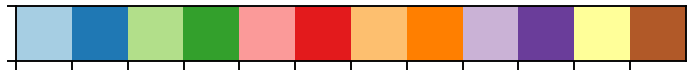

In [5]:
sns.set_context('talk')
sns.palplot(sns.color_palette("Paired"))

In [6]:
# Gaussian thermal distribution after drop (assuming initial point source, 40 ms should be fine for this)
def gauss_thermal(x, T, A):
    KB = 1.380649E-23 # Boltzmann constant [J/K]
    AMU = ufloat(1.66053906660, 0.00000000050)*1E-27
    
    # Working with 84Sr
    M = ufloat(83.9134191, 0.0000013)*AMU
    M = M.nominal_value
    
    sigma_0 = 0
    t_drop = 40E-3
    
    numer = np.exp((-1/2)*(x**2)/(sigma_0**2 + KB*T*t_drop**2/M))
    denom = np.sqrt(2*np.pi)*np.sqrt(sigma_0**2 + KB*T*t_drop**2/M)
    
    out = A*numer/denom
    
    return out

In [7]:
# Trying a colorbar thing:
# https://joseph-long.com/writing/colorbars/
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

In [8]:
# Read in data from .xlsx file.

# Sheet# where #=evaporation time.
sheets = ['Sheet1', 'Sheet2', 'Sheet3', 'Sheet4', 'Sheet5', 'Sheet6', 'Sheet7', 'Sheet8', 'Sheet9', 'Sheet10', 'Sheet11']

data_sheet = pd.read_excel('SheetTrap-Evap-Drop141947.xlsx', sheet_name=sheets, header=None)
data_dimple = pd.read_excel('RedDimple-Evap-Drop143755.xlsx', sheet_name=sheets, header=None)

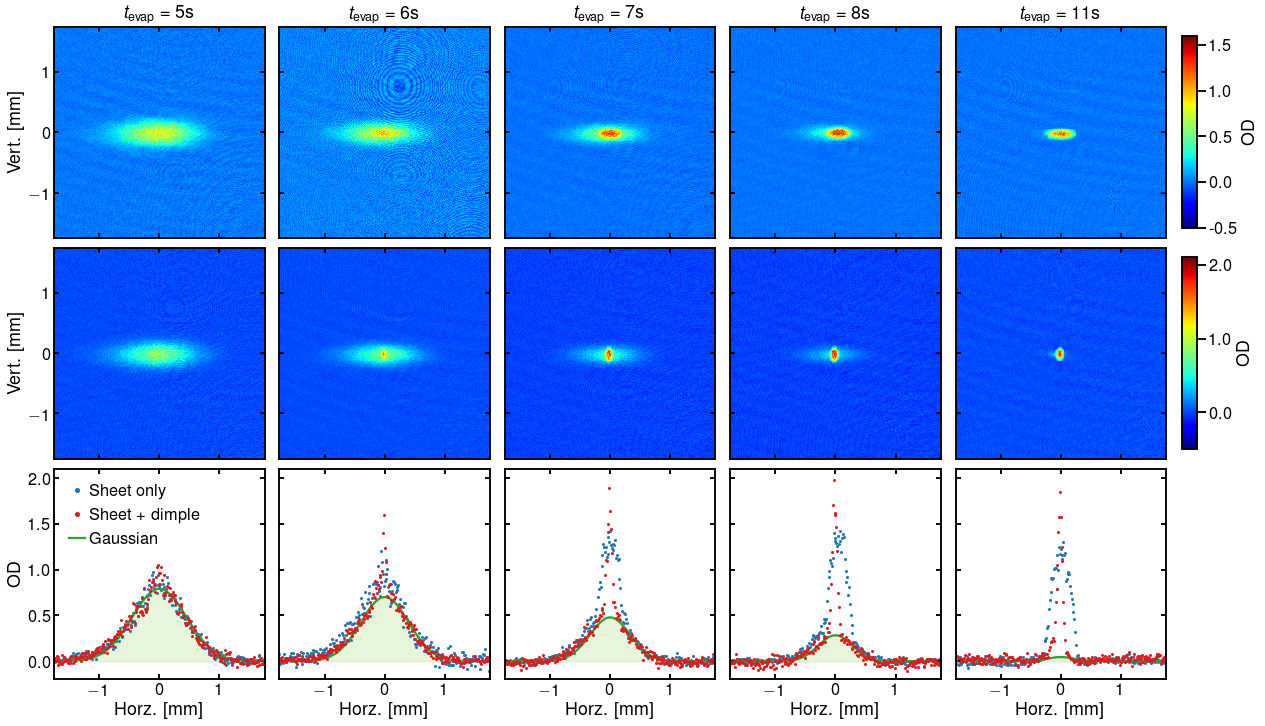

In [20]:
# What to plot
evap_times = [5, 6, 7, 8, 11]
od_plot_x_lims = (-1.75, 1.75)
od_plot_y_lims = (-1.75, 1.75)

# Absorption image information
[dim_x, dim_y] = [301, 301]
#pixel_size = 14.1 # 14.1 um/pixel
pixel_size = 14.1/1000 # 14.1/1000 mm/pixel

[X, Y] = [np.arange(start=0, stop=dim_x, step=1), np.arange(start=0, stop=dim_y, step=1)]
# Center at zero
X = (X - 150)*pixel_size
Y = (Y - 150)*pixel_size

[fig, axs] = plt.subplots(nrows=3, ncols=len(evap_times), figsize=(4*len(evap_times), 4*3), sharex=True, sharey=False)

# Plot OD images
for idx, time in enumerate(evap_times):
    sheet_name = 'Sheet' + str(time)
    
    ### Sheet-only OD plot
    sheet_plot = axs[0, idx].pcolormesh(X, Y, data_sheet[sheet_name], cmap='jet', vmin=-0.5, vmax=1.6)
    axs[0, idx].set_aspect('equal')
    #print(np.min(np.min(data_sheet[sheet_name])))
    #print(np.max(np.max(data_sheet[sheet_name])))
    #axs[0, idx].set_xlim((min(X), max(X)))
    axs[0, idx].set_xlim(od_plot_x_lims)
    axs[0, idx].set_ylim(od_plot_y_lims)
    
    ### Dimple+sheet OD plot
    dimple_plot = axs[1, idx].pcolormesh(X, Y, data_dimple[sheet_name], cmap='jet', vmin=-0.5, vmax=2.1)
    axs[1, idx].set_aspect('equal')
    #print(np.min(np.min(data_dimple[sheet_name])))
    #print(np.max(np.max(data_dimple[sheet_name])))
    #axs[1, idx].set_xlim((min(X), max(X)))
    axs[1, idx].set_xlim(od_plot_x_lims)
    axs[1, idx].set_ylim(od_plot_y_lims)
    
    ### Cross-section plots
    # Find [row, col] index of max value then plot
    df = data_sheet[sheet_name]
    v = df.values
    i, j = [x[0] for x in np.unravel_index([np.argmax(v)], v.shape)]
    [max_row, max_col] = [df.index[i], df.columns[j]]
    data_cut = df.values[max_row,:]
    axs[2, idx].plot(X, data_cut, '.', zorder=1, markersize=4, color=sns.color_palette("Paired")[1],
                     label=r'Sheet only')
    
    # Find [row, col] index of max value then plot
    df = data_dimple[sheet_name]
    v = df.values
    i, j = [x[0] for x in np.unravel_index([np.argmax(v)], v.shape)]
    [max_row, max_col] = [df.index[i], df.columns[j]]
    data_cut = df.values[max_row,:]
    axs[2, idx].plot(X, data_cut, '.', zorder=2, markersize=4, color=sns.color_palette("Paired")[5],
                     label=r'Sheet + dimple')
    
    axs[2, idx].set_xlim(od_plot_x_lims)
    axs[2, idx].set_ylim((-0.2, 2.1))
    
    asp = np.diff(axs[2, idx].get_xlim())[0] / np.diff(axs[2, idx].get_ylim())[0]
    axs[2, idx].set_aspect(asp)

### Adding colorbars 
# Sheet OD plots
bbox = axs[0,-1].get_position()
cax = fig.add_axes([bbox.x1+0.01, bbox.y0-0.01, 0.01, bbox.y1-bbox.y0])
clb = fig.colorbar(sheet_plot, cax=cax, format='%0.1f')
clb.set_label('OD')

# Sheet + dimple OD plots
bbox = axs[1,-1].get_position()
cax = fig.add_axes([bbox.x1+0.01, bbox.y0, 0.01, bbox.y1-bbox.y0])
clb = fig.colorbar(dimple_plot, cax=cax,  format='%0.1f')
clb.set_label('OD')

### Adding thermal Gaussian to cross-section plots
x = np.linspace(X[0], X[-1], num=500, endpoint=True) # [mm]

# I got the fitted params from the .mat file and converted sigma_x to temperature and amplitude to A.
# Note vertical temperature is generally lower than the horizontal temperature.
T = 1.3E-6
A = 9E-4
axs[2, 0].plot(x, gauss_thermal(x*1E-3, T, A), zorder=1,
               color=sns.color_palette("Paired")[3], label=r'Gaussian')
axs[2, 0].fill_between(x, 0, gauss_thermal(x*1E-3, T, A), zorder=0,
                       color=sns.color_palette("Paired")[2], alpha=0.3)

T = 1.0E-6
A = 7E-4
axs[2, 1].plot(x, gauss_thermal(x*1E-3, T, A), zorder=1,
               color=sns.color_palette("Paired")[3], label=r'Gaussian')
axs[2, 1].fill_between(x, 0, gauss_thermal(x*1E-3, T, A), zorder=0,
                       color=sns.color_palette("Paired")[2], alpha=0.3)

T = 700E-9
A = 4E-4
axs[2, 2].plot(x, gauss_thermal(x*1E-3, T, A), zorder=1,
               color=sns.color_palette("Paired")[3], label=r'Gaussian')
axs[2, 2].fill_between(x, 0, gauss_thermal(x*1E-3, T, A), zorder=0,
                       color=sns.color_palette("Paired")[2], alpha=0.3)

T = 500E-9
A = 2E-4
axs[2, 3].plot(x, gauss_thermal(x*1E-3, T, A), zorder=1,
               color=sns.color_palette("Paired")[3], label=r'Gaussian')
axs[2, 3].fill_between(x, 0, gauss_thermal(x*1E-3, T, A), zorder=0,
                       color=sns.color_palette("Paired")[2], alpha=0.3)

T = 300E-9
A = 2.5E-5
axs[2, 4].plot(x, gauss_thermal(x*1E-3, T, A), zorder=1,
               color=sns.color_palette("Paired")[3], label=r'Gaussian')
axs[2, 4].fill_between(x, 0, gauss_thermal(x*1E-3, T, A), zorder=0,
                       color=sns.color_palette("Paired")[2], alpha=0.3)

### Axis stuff
# Add subplot titles above just the sheet trap (top row) plots
for idx, time in enumerate(evap_times):
    subplot_title = r'$t_{\text{evap}} = {%d}$\si{\second}' %(time)
    axs[0, idx].title.set_text(subplot_title)

for ax in axs.flat:
    ax.tick_params(direction='in', axis='both', which='both', bottom=True, top=True, left=True, right=True, length=5)
    ax.label_outer()

# Axes labels
axs[0, 0].set_ylabel(r'Vert. [\si{\mm}]')
axs[1, 0].set_ylabel(r'Vert. [\si{\mm}]')
axs[2, 0].set_ylabel(r'OD')
for ax in axs[-1,:]:
    ax.set_xlabel(r'Horz. [\si{\mm}]')

bbox = axs[2,-1].get_position()
#axs[2,-1].legend(frameon=False, bbox_to_anchor=(bbox.x0+bbox.x1+0.05, 0.5), loc='right', borderaxespad=0, handletextpad=0.1, markerscale=3)
axs[2,0].legend(frameon=False, loc='upper left', handletextpad=0.2, markerscale=2, handlelength=1)

# Figure title
#fig.suptitle(t=r'Absorption images after \SI{40}{\ms} drop', fontsize=20)

#plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig('sheet_dimple_comparison-drop.pdf', bbox_inches='tight')

plt.show()